# Demystifying LUNA
### 15688 Final Project
#### Yuchen Cao (yuchenc1)
#### Yao Yao (yaoy2)
#### Jingying Wang (jingyinw)

### I. Introduction

In 2018, 1,735,350 new cancer cases and 609,640 cancer deaths are projected to occur in the United States. Over the past decades, Lung cancer has become one of the leading causes of cancer-related deaths. Even worse, advances have been slow for lung cancer in contrast to the steady increase in survival for most other cancers. The low survival rate of lung cancer is partly because more than one-half of cases are diagnosed at a distant stage.[1]
<img src="fig 1.png" alt="Drawing" style="width: 300px;"/>

Luckily, there is a great potential for lung cancer to be diagnosed at an earlier stage through the use of screening with low-dose computed tomography, which has been shown to reduce lung cancer mortality by up to 20% among current and former smokers with a smoking history of 30 or more pack-years.$^2$$^,$$^3$ Recently, millions of CT scans are to be analyzed in CT lung cancer screening process. In order to reduce the massive burden for radiologists, our project aims to develop computer algorithms to optimize CT lung cancer screening.

The very first and essential step in the analysis of lung cancer screening CT scans is to detect pulmonary nodules. However, pulmonary nodules may or may not represent early-stage lung cancer, which needs further screening in later steps. Many Computer-Aided Detection (CAD) systems have already been proposed for the pulmonary nodule detection task.

Our project will focus on a large-scale evaluation of automatic pulmonary nodule detection algorithms on the LUNA (Lung Nodule Analysis) 2016 dataset. The purpose of our project is to develop an automatic lung nodule detection algorithm on CT scans. The raw dataset is extremely unbalanced with the number of negative samples is 20 times as many as that of positive ones. We will be rotating positive samples along x, y, and z axis by 90, 180, and 270 degrees to balance the data in Section II. Other data preprocessing will also be shown in this section. In Section III, we will be using a pretrained model, C3D Convolutional Neural Network, to leverage the information provided by the CT scans, instead of traditional 2D CNN. Finally, the results of the model will be presented in Section IV.

### II. Modules

We start importing required modules / libraries  using the import command from python

In [2]:
import SimpleITK as sitk
import numpy as np
import csv
import os
import time
import random
import torch as tc
from PIL import Image
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [18, 16]
%matplotlib inline

### III. The Dataset

The original data set consists of 10 subsets and are designed for 10-fold cross validation. In our implementation, we combine all data under one directory because we found this way could simplify the preprocessing workflow. Every CT scan instance is assiciated with one `.mhd` file as well as one `.raw` file. In this project, we primarily worked with the `.mhd` file, using the industrial standard package, SimpleITK, for medical imaging analysis. 

Training a model using supervised-learning also requires labeled data. Such data in the LUNA2016 data set is stored in `candidates.csv` file, each line of the file corresponds to one nodule and its assignment by medical professionals. More specifically, every nodule is found in a file specified by the first field. The next three fields specify the coordinate where that nodule is found, followed by the class label indicating whether the nodule is classified as malicious or not. The layout of `candidates.csv` is illustrated below.

In [2]:
import pandas as pd

cand_path = '../subset0/candidates.csv'
df = pd.read_csv(cand_path)
df.head()

seriesuid  coordX  coordY  coordZ  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  -56.08  -67.85 -311.92   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...   53.21 -244.41 -245.17   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.66 -121.80 -286.62   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  -33.66  -72.75 -308.41   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  -32.25  -85.36 -362.51   

   class  
0      0  
1      0  
2      0  
3      0  
4      0

### IV. Preprocessing
To begin with, we need to extract all labeled data and find their location in the CT scans. We will do this by reading in `.mhd` files using the IO tool provided by SimpleITK, and then we extract the array that contains pixel values for each scan. Also, we will take advantage of some SimpleITK operations to acquire the origin and spacing associated with each scan, for reasons that we will explain later. 

In [ ]:
def readCSV(filename):
    lines = []
    with open(filename, "rt") as f:
        csvreader = csv.reader(f)
        for line in csvreader:
            lines.append(line)
    return lines

cands = readCSV(cand_path)

In [3]:
def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
     
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
     
    return numpyImage, origin, spacing

In `candidates.csv`, notice that the coordinates, regardless of axis, are displayed with digit, meaning that they cannot be used directly to index into the CT scans. In other words, they need to be transformed into integer values, or voxels, more specifically. The transformation works as the following.

First, we will subtract the origin value from every coordinate. This will ensure that the "first" pixel on all axis will be oriented as (0, 0, 0). Next, notice that the CT scan is performed by taking X-ray "slices", each slice has some spacing, specified by the `spacing` variable from the `load_itk_image` function. Every spacing corresponds to one voxel on the z-axis. Therefore, the zero-aligned coordinates will finally turn into voxel values once it is divided by the spacing value.

The implementation of the transformation is shown below.

In [5]:
def worldToVoxelCoord(worldCoord, origin, spacing):
    return np.absolute(worldCoord - origin) / spacing

Once we index into the desired voxel, we can carve out the nodules. Before we feed them into the 3D CNN, however, one more thing need to be taken care. 

In an image-based CNN application, the feature are pixel values. Unlike normal images with rgb pixel range, CT scans are quantified by so-called Housefield units, which are roughtly equivalent to the absorbance of X-ray by different types of physiological material. For lung CT scans, we are typically interested in regions with Housefield units ranging from -1000 to 400. 

In addition, it is usually common practice to ensure that feature values are maintained on the same numerical scale. Therefore, the following code truncate the undesired regions, and perform normalization.

In [6]:
def normalizePlanes(npzarray):
     
    maxHU = 400.
    minHU = -1000.
 
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

### V. Positive Proliferation

With a quick glance of `candidates.csv`, one could easily tell that the labeled data are highly unbalanced. Most of CT instances indicate the absence of malignancy, which is what we expect through life experience. However, such physical fact becomes a pitfall and thus must be handled. A preliminary proliferation of malicious nodules involves the following thought experiment.

The original data can be viewed as one starring at the data on the xy-plane defined by its world coordinate system. However, if we change the viewpoint, we are still looking at a positive instance, which effectively add more instances into positives. In light of this, we "viewed" the data from different perspectives by manipulating axis associated with the numpy array. More specifically, we rotate a positive nodule by 90, 180, and 270 degrees along three axis, respectively. This will generate $3\times 3 = 9$ extra instances, which results in a 10-fold proliferation after including the original nodule itself. The code for positive proliferation is shown below.

In [ ]:
def generate_view(cube):
    generated_cubes = [cube]

    for i in range(3):
        generated_cubes.append(np.rot90(cube, i+1, (0,1)))
        generated_cubes.append(np.rot90(cube, i+1, (0,2)))
        generated_cubes.append(np.rot90(cube, i+1, (1,2)))

    return generated_cubes

Finally, we connected the preprocessing workflow via the following pipelining code.

In [92]:
import time

def slice(cands, voxelWidth=65):
    cubes = []
    labels = []
    
    files = set()
    curr = time.time()
    
    counter = 0
    num = 0

    for cand in cands:
        # load image
        img_path = '../subset1/' + cand[0] + '.mhd'

        try:
            numpyImage, numpyOrigin, numpySpacing = load_itk_image(img_path)
        except RuntimeError:
            continue

        if img_path not in files:
            files.add(img_path)
            print("adding new file", img_path)

        # new part: generate positives here
        if int(cand[4]) == 1:
            worldCoord = np.asarray([float(cand[3]),float(cand[2]),float(cand[1])])
            voxelCoord = worldToVoxelCoord(worldCoord, numpyOrigin, numpySpacing)
            
            pos = [voxelCoord[0]-voxelWidth/2, voxelCoord[0]+voxelWidth/2, voxelCoord[1]-voxelWidth/2, voxelCoord[1]+voxelWidth/2, voxelCoord[2]-voxelWidth/2, voxelCoord[2]+voxelWidth/2]
            pos = [int(i) for i in pos]
            patch = numpyImage[pos[0]:pos[1],pos[2]:pos[3],pos[4]:pos[5]]
            patch = normalizePlanes(patch)
            
            if patch.shape == (voxelWidth, voxelWidth, voxelWidth):               
                cubes.extend(generate_view(patch))
                if len(cubes) % 1000 == 0:
                    counter += 1
                    print("1000 positive generated, time", time.time() - curr)
                    curr = time.time()
                    np.save('positives-'+str(counter), cubes)                    
                    cubes = []

In [5]:
positives = np.load('positives.npy')
print(len(positives))

1140


In [27]:
import math

def plot_images(X, rows, cols):
    """ Plots the centers in a (row by col) grid
        Args: 
            centers (numpy 2D matrix) : matrix of centers, each row is a center
            rows (int) : number of rows to plot in a grid
            cols (int) : number of cols to plot in a grid
        Returns: 
            (list) : list of matplotlib.image.AxesImage objects
    """
    list = []
    
    for i in range(rows*cols):
        plt.subplot(rows, cols, i+1)
        list.append(plt.imshow(X[i, :, :], cmap='gray'))
        
    return list
    pass
    

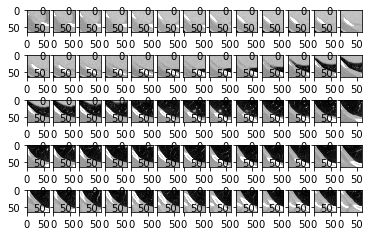

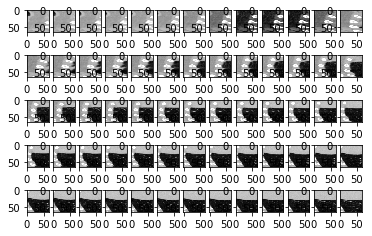

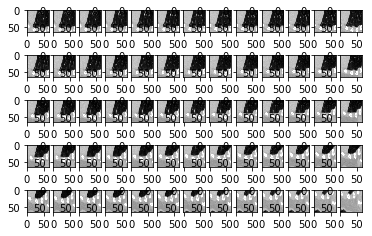

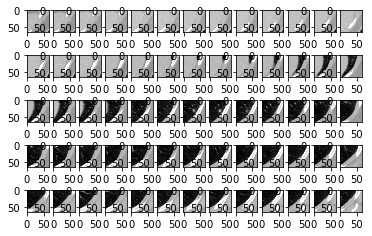

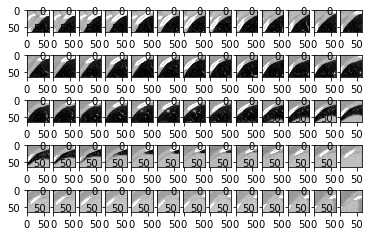

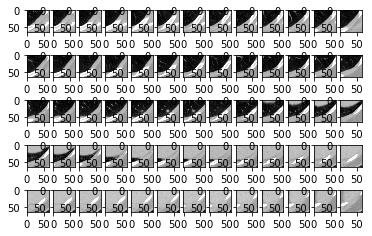

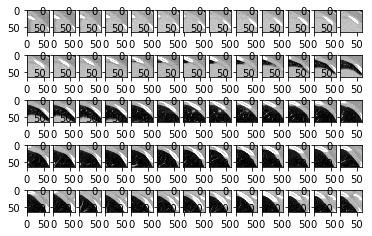

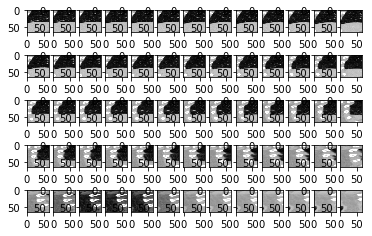

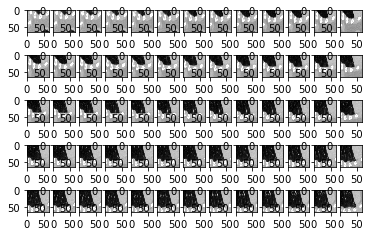

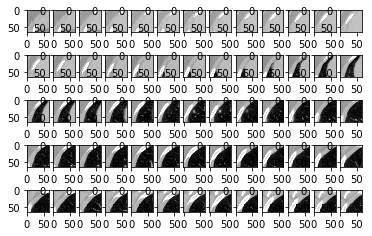

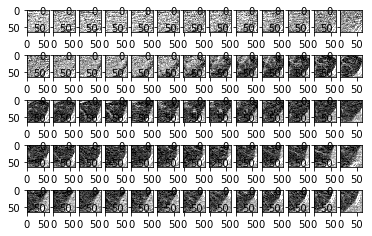

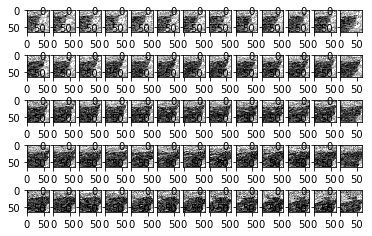

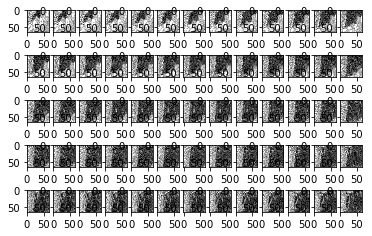

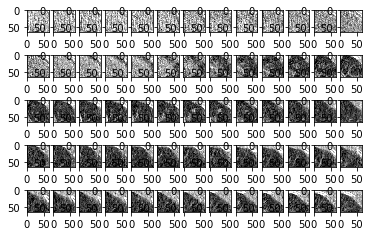

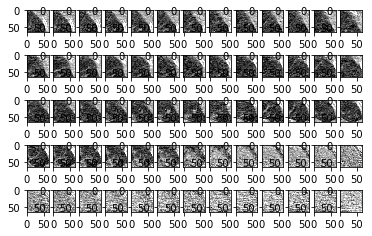

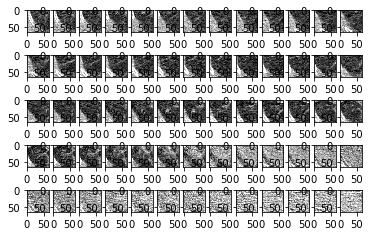

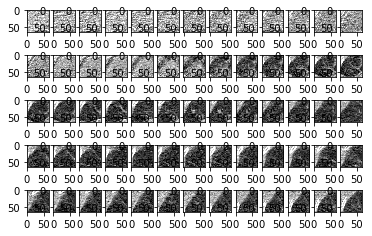

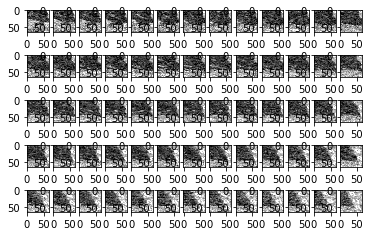

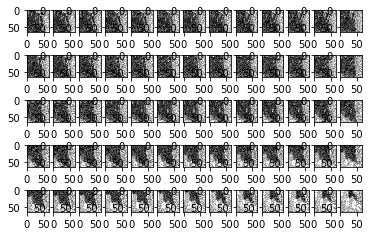

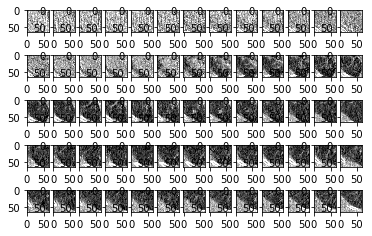

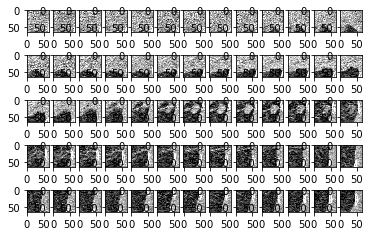

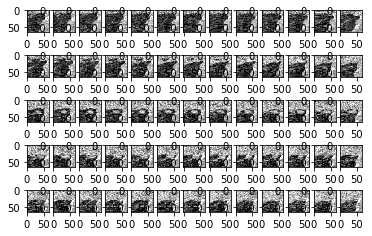

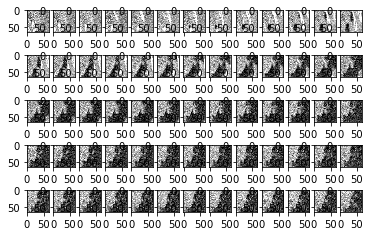

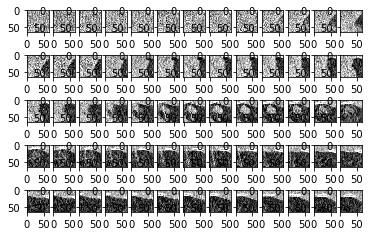

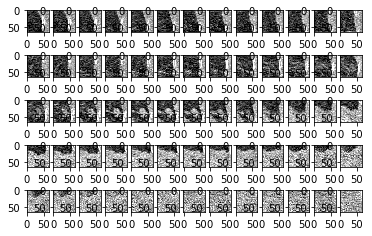

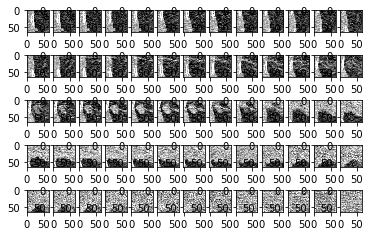

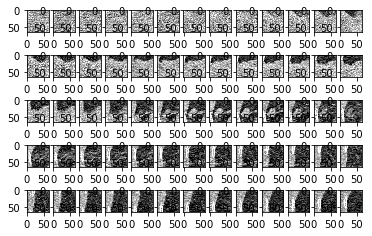

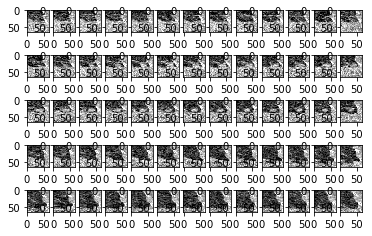

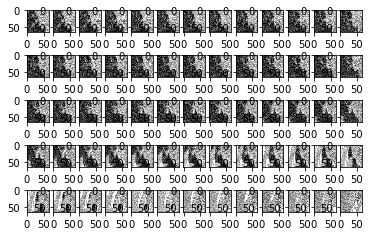

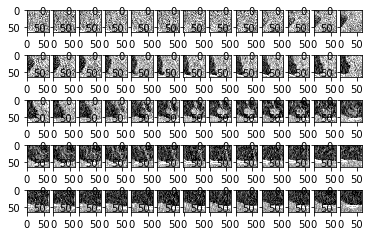

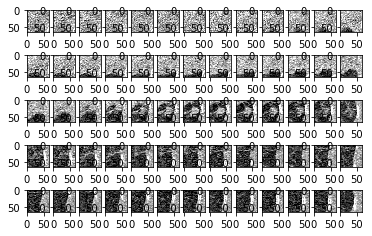

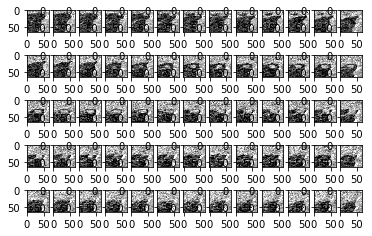

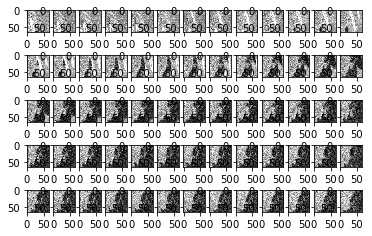

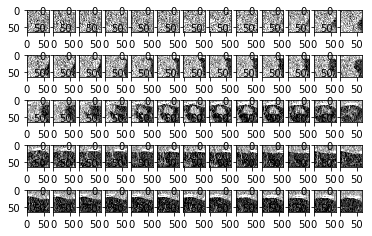

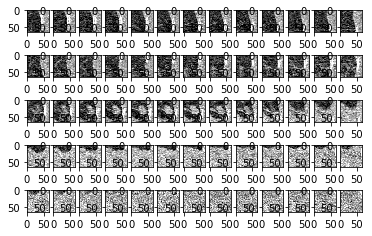

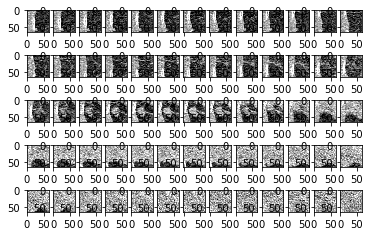

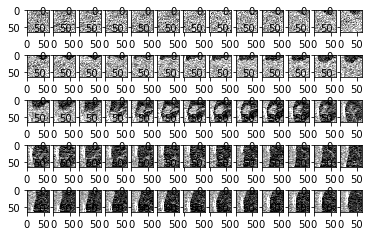

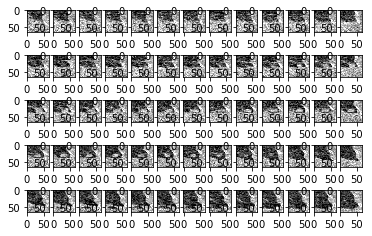

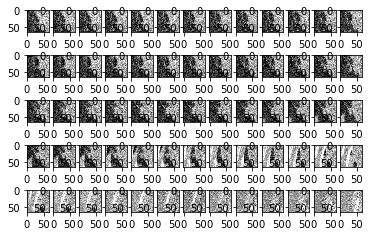

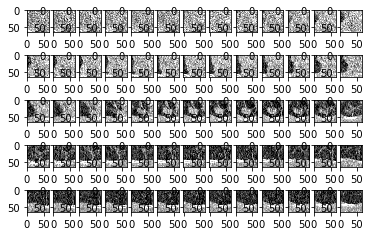

In [28]:
for p in positives:
    plot_images(p, 5, 13)
    plt.show()

### VI. Convolutional Netural Network

After we have generated the positive instances, we have prepared a nice balanced data set to do some important analysis. There are a lot of datas in the original dataset. However, due to the limitation of time, machine and money, we could only use part of it to fit into a machine learning model. After careful consideration, we decide to choose 2 subsets of original data along with the positive data we have generated. The two chosen subsets contain a total of 1999 instances. And we have generated 1140 positive instances. So we will get a total of 3139 instances.

In a machine learning project, researchers will often split all the instances into 3 parts： train, validation, test. We will divide our data set into 3 parts in a rate of 7:2:1. We will use the train set to train our CNN model, use the validation set to see the performance on the validation set and finally use the test set to see the final result.

<img src="data split.png" alt="Drawing" style="width: 600px;"/>

We are going to write a function to load data and split data for use.

In [4]:
def load_data():
    x1 = np.load('./cubes-0.npz')['cubes']
    y1 = np.load('./labels-0.npz')['labels']
    x2 = np.load('./cubes-1.npz')['cubes']
    y2 = np.load('./labels-1.npz')['labels']
    pos = np.load('./positives.npy')
    pos_y = np.array([1] * len(pos))
    cut1_1 = int(len(x1)*0.1)
    cut2_1 = int(len(x2)*0.1)
    cut3_1 = int(len(pos)*0.1)
    cut1_2 = int(len(x1)*0.3)
    cut2_2 = int(len(x2)*0.3)
    cut3_2 = int(len(pos)*0.3)
    xtest = np.concatenate((x1[:cut1_1], x2[:cut2_1], pos[:cut3_1]), axis=0)
    testlabel = np.concatenate((y1[:cut1_1], y2[:cut2_1], pos_y[:cut3_1]), axis=0)
    xvalid = np.concatenate((x1[cut1_1:cut1_2], x2[cut2_1:cut2_2], pos[cut3_1:cut3_2]), axis=0)
    validlabel = np.concatenate((y1[cut1_1:cut1_2], y2[cut2_1:cut2_2], pos_y[cut3_1:cut3_2]), axis=0)
    xtrain = np.concatenate((x1[cut1_2:], x2[cut2_2:], pos[cut3_2:]), axis=0)
    xlabel = np.concatenate((y1[cut1_2:], y2[cut2_2:], pos_y[cut3_2:]), axis=0)
    return xtrain, xlabel, xvalid, validlabel, xtest, testlabel


We are going to look for a suitable model for our project. According to recent studies, Convolutional Neural Network is a powerful model for its excellent performance on image recognition and classification. Usually, the architecture of the neural network is the fundamental part of the project. However, there are some wonderful experience from researchers. We decide to use a C3D network because our input data is a 3D cube with a length of 65. Also, I have made a few modifications to let the model fit the input shape. Finally, we use 8 convolutional layers and 6 pooling layers together to form our network. The following figure is the illustration of our model architecture.

<img src="model.png" alt="Drawing" style="width: 800px;"/>

PyTorch is an open source machine learning library for Python, based on Torch. It is primarily developed by Facebook's artificial-intelligence research group. It is very popular nowadays due to its convenience and excellent performance. With PyTorch, we could easily build our own deep learning model by just calling some APIs. Here is our code implementation of the above architecture.

In [5]:
class Net(tc.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = cnn_module()

    def forward(self, x, train):
        for i in range(0, 18):
            x = self.layers[i](x)
        x1 = self.layers[20](self.layers[19](self.layers[18](x)))
        x2 = self.layers[22](self.layers[21](x))
        return tc.cat((x1, x2), 1)
    
def cnn_module():
    main = tc.nn.Sequential()
    # 65 * 65 * 65 , 1
    main.add_module('avg_pool_1', tc.nn.AvgPool3d((2, 2, 2), stride=(2, 1, 1)))
    # 32 * 64 * 64 , 1
    main.add_module('conv_3d_1', tc.nn.Conv3d(1, 32, 3, 1, 1))
    main.add_module('relu_1', tc.nn.ReLU())
    # 32 * 64 * 64 , 32
    main.add_module('max_pool_1', tc.nn.MaxPool3d((1, 2, 2), stride=(1, 2, 2)))
    # 32 * 32 * 32 , 32
    main.add_module('conv_3d_2', tc.nn.Conv3d(32, 64, 3, 1, 1))
    main.add_module('relu_2', tc.nn.ReLU())
    # 32 * 32 * 32 , 64
    main.add_module('max_pool_2', tc.nn.MaxPool3d((2, 2, 2), stride=(2, 2, 2)))
    # 16 * 16 * 16 , 64
    main.add_module('conv_3d_3', tc.nn.Conv3d(64, 128, 3, 1, 1))
    main.add_module('relu_3', tc.nn.ReLU())
    # 16 * 16 * 16 , 128
    main.add_module('max_pool_3', tc.nn.MaxPool3d((2, 2, 2), stride=(2, 2, 2)))
    # 8 * 8 * 8 , 128
    main.add_module('conv_3d_4', tc.nn.Conv3d(128, 256, 3, 1, 1))
    main.add_module('relu_4', tc.nn.ReLU())
    # 8 * 8 * 8 , 256
    main.add_module('max_pool_4', tc.nn.MaxPool3d((2, 2, 2), stride=(2, 2, 2)))
    # 4 * 4 * 4, 256
    main.add_module('conv_3d_5', tc.nn.Conv3d(256, 512, 3, 1, 1))
    main.add_module('relu_5', tc.nn.ReLU())
    # 4 * 4 * 4 , 512
    main.add_module('max_pool_5', tc.nn.MaxPool3d((2, 2, 2), stride=(2, 2, 2)))
    # 2 * 2 * 2 , 512
    main.add_module('conv_3d_6', tc.nn.Conv3d(512, 64, 2, 1, 0))
    main.add_module('relu_6', tc.nn.ReLU())
    # 1 * 1 * 1 , 64
    main.add_module('conv_3d_7', tc.nn.Conv3d(64, 1, 1, 1, 0))
    main.add_module('sigmoid_1', tc.nn.Sigmoid())
    # 1 * 1 * 1 , 1
    main.add_module('flatten_1', Flatten())

    main.add_module('conv_3d_8', tc.nn.Conv3d(64, 1, 1, 1, 0))
    main.add_module('flatten_2', Flatten())
    return main

class Flatten(tc.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        n = x.shape[0]
        m = x.shape[1]
        x = x.view(n, m)
        return x

We could find that the code implementation is very easy and only contains only a few lines of code. I create a class called Net, which is actually our model and add 22 layers into the model by just calling pyTorch functions. You can notice that I have created a new class called Flatten because pyTorch seems to have no support for this function. But this function is very easy, we do not have to worry about it.

Also, when we want to train the model, all the parameters in the model should not be initialize to 0 because in this way, the performance at first is bad and it needs more epoches to get a good performance. So we have to initialize our parameters randomly. What's more, in deep learning project, it is very important to use batch because we always have a huge amount of data. If we want to throw all our data into the model to compute, it will cost a lot of time and memory, which is impossible for modern computer. Also using batch could help avoid over-fitting. Scholars have a conclusion that the batch size could not be bigger than 32. So we will use 32 as the batch size. The following is our implementation of initialization of weights and the function of creating batch randomly.

In [7]:
def weights_init(m):
    if isinstance(m, tc.nn.Conv3d):
        tc.nn.init.xavier_normal_(m.weight)
        m.bias.data.zero_()
    return

def create_batch(x, y, batch_size):
    num_instance = [i for i in range(len(x))]
    r = random.sample(num_instance, batch_size)
    batch_x = np.empty(0)
    batch_y = np.empty(0)
    for i in r:
        batch_x = np.append(batch_x, x[i])
        batch_y = np.append(batch_y, y[i])
    return np.reshape(batch_x, (int(batch_size),1,65,65,65)), batch_y

### VII. Train Process

Now since we have everything prepared, we are going to train our model. Attention, the code below which has .cude() means that we are going to use GPU to deal with this step. We recommend that you use GPU to train the model. But if you do not have a GPU machine with CUDA, you can delete all the .cuda() in the code below to train the model using CPU. This is appropriate, but it will cost a lot of time.

In [8]:

# this is the parameters we are going to use in the train process
params = {}
params['train_epoch'] = 30
params['batch_size'] = 32
params['learning_rate'] = 0.01
params['momentum'] = 0.9
params['weight_decay'] = 0.0001

xtrain, xlabel, xvalid, validlabel, xtest, testlabel = load_data()
print(len(xtrain))
print(len(xvalid))
print(len(xtest))

2198
628
313


In [10]:
model = Net().cuda()
# if you have saved the checkpoint, you could uncomment next line 
# and comment the model.apply() line to start from former checkpoint
# model.load_state_dict(tc.load('./checkpoint.pt'))
model.apply(weights_init)
model.train()

optimizer = tc.optim.SGD(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'], momentum=params['momentum'])

print('-'*80)
print('start training')
for epoch in range(1, params['train_epoch']+1):
    print('-'*80)
    start = time.time()
    count = 0
    train_loss = []
    for i in range(int(len(xtrain)/params['batch_size'])):
        data, label = create_batch(xtrain, xlabel, params['batch_size'])
        data, label = tc.autograd.Variable(tc.FloatTensor(data), requires_grad=True).cuda(), tc.autograd.Variable(tc.FloatTensor(label)).cuda()
        optimizer.zero_grad()
        output = model(data, train=True).cuda()
        output_label = output.data.max(1, keepdim=True)[1].cpu().numpy()
        index = 0
        for y in output_label:
            if y[0] != label[index]:
                count += 1
            index += 1
        loss = tc.nn.functional.cross_entropy(output.float(), label.long())
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
    print('epoch ' + str(epoch) + ' finishes in ' + str(time.time() - start))
    error_rate = count / len(xlabel)
    print('train error rate: ' + str(error_rate))
    print('train cross cross_entropy loss： ' + str(sum(train_loss)))
    
    print('-'*80)
    min_error_rate = 1
    count = 0
    for i in range(int(len(xvalid)/params['batch_size'])):
        data, label = create_batch(xvalid, validlabel, params['batch_size'])
        data = tc.autograd.Variable(tc.FloatTensor(data), volatile=True).cuda()
        output = model(data, train=False).cuda().data.max(1, keepdim=True)[1].cpu().numpy()
        index = 0
        for y in output:
            if y[0] != label[index]:
                count += 1
            index += 1
    error_rate = count/len(validlabel)
    if error_rate < min_error_rate:
        tc.save(model.state_dict(), './checkpoint.pt')
        min_error_rate = error_rate
    print('validation error rate: ' + str(error_rate))

print('-'*80)
model.eval()
count = 0
for i in range(int(len(xtest)/params['batch_size'])):
    data, label = create_batch(xtest, testlabel, params['batch_size'])
    data = tc.autograd.Variable(tc.FloatTensor(data), volatile=True).cuda()
    output = model(data, train=False).cuda().data.max(1, keepdim=True)[1].cpu().numpy()
    index = 0
    for y in output:
        if y[0] != label[index]:
            count += 1
        index += 1
print('test error rate: ' + str(count/len(testlabel)))

--------------------------------------------------------------------------------
start training
--------------------------------------------------------------------------------
epoch 1 finishes in 63.69337296485901
train error rate: 0.3544131028207461
train cross cross_entropy loss： 44.140107214450836
--------------------------------------------------------------------------------


C:\Users\Coura\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


validation error rate: 0.37261146496815284
--------------------------------------------------------------------------------
epoch 2 finishes in 63.14920449256897
train error rate: 0.3289353958143767
train cross cross_entropy loss： 42.21274220943451
--------------------------------------------------------------------------------
validation error rate: 0.3105095541401274
--------------------------------------------------------------------------------
epoch 3 finishes in 62.99611830711365
train error rate: 0.3093721565059145
train cross cross_entropy loss： 40.75799313187599
--------------------------------------------------------------------------------
validation error rate: 0.2659235668789809
--------------------------------------------------------------------------------
epoch 4 finishes in 62.98718285560608
train error rate: 0.1897179253867152
train cross cross_entropy loss： 29.97235542535782
--------------------------------------------------------------------------------
validation e

validation error rate: 0.12101910828025478
--------------------------------------------------------------------------------
epoch 27 finishes in 60.85943651199341
train error rate: 0.0
train cross cross_entropy loss： 0.0023261085152626038
--------------------------------------------------------------------------------
validation error rate: 0.11305732484076433
--------------------------------------------------------------------------------
epoch 28 finishes in 60.195796251297
train error rate: 0.0
train cross cross_entropy loss： 0.0018673539161682129
--------------------------------------------------------------------------------
validation error rate: 0.11464968152866242
--------------------------------------------------------------------------------
epoch 29 finishes in 59.464648962020874
train error rate: 0.0
train cross cross_entropy loss： 0.0017879270017147064
--------------------------------------------------------------------------------
validation error rate: 0.1321656050955414

C:\Users\Coura\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


test error rate: 0.08945686900958466


### VIII. Results

With a GPU 1080, each epoch takes around 65 seconds to train. After 20 epoch, the results tend to be very good.
<img src="result1.png" alt="Drawing" style="width: 300px;"/>
<img src="result2.png" alt="Drawing" style="width: 300px;"/>
Our model gives an accuracy of around 92% on the test data.

### References
1. Siegel RL, Miller KD, Jemal A. Cancer statistics, 2018. CA CANCER J CLIN 2017;67:7–30
2. National Lung Screening Trial Research Team, Aberle DR, Adams AM, et al. Reduced lung-cancer mortality with lowdose computed tomographic screening. N Engl J Med. 2011;365:395-409. 
3. Marcus PM, Doria-Rose VP, Gareen IF, et al. Did death certificates and a death review process agree on lung cancer cause of death in the National Lung Screening Trial? Clin Trials. 2016;13:434-438